In [1]:
# same window width but shifted consistently, because the onset for cluster 3 is later tthan cluster2
"""
# for RF constrained units, plot time to first spike distribution
# 1. time to first spike across driver and driven population (in each area) for each trial
# 2. time to first spike for individual neurons across trials

"""

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy as sp
import os, sys,glob, copy
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
import seaborn as sns

import TTP_utils as TTP_utils

from scipy.ndimage.filters import gaussian_filter
from scipy.stats.mstats import zscore

import visualization_utils as vu

import TT_first_spike as tf
#import TTF_detection_Poisson as sdp
#reload(sdp)
import TTF_dist_fit as dist_fit


In [2]:
def get_area_for_probe(probenames):
    areas_all = ['AM','PM','V1','LM','AL','RL']
    probes_all = ['probeA','probeB','probeC','probeD','probeE','probeF']
    return [areas_all[np.where(np.array(probes_all)==probe)[0][0]] for probe in probenames]


In [3]:
from scipy.signal import find_peaks
def find_psth_peaks(x, prominence=1, width=20):
    peaks, properties = find_peaks(x, prominence=prominence, width=width)
    #print(properties["prominences"], properties["widths"])
    return peaks, properties

# load spikes data constrain to RF

In [21]:
mouse_IDs = ['306046','388523', '389262',  '408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356','416861','419112','419116']

mouse_ID = mouse_IDs[1]

# 1. load spikes
basepath = '/Users/xiaoxuanj/work/work_allen/Ephys/mouse'+mouse_ID
spikes = dl.load_npz(basepath+'/matrix/drifting_grating_cortex.npz')
spikes_rep = dl.load_npz(basepath+'/matrix/drifting_grating_cortex_rep.npz')

df_tmp = dl.data_loader(mouse_ID, datatype='units_cortex')[0]
df=pd.read_csv('/data/matrix_RF/meta_cluster_RF/mouse'+mouse_ID+'_meta_cluster_RF.csv', index_col=0)
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0.1.1'])
print(len(df),len(df_tmp))

# 2. select units with RF on screen (already satisfy FR>2)
select_idx = []
for idx, row in df_tmp.iterrows():
    probe_id=row['probe_id']
    unit_id=row['unit_id']
    if unit_id in df[df.probe_id==probe_id].unit_id.values:
        select_idx.append(idx)      
df_tmp=df_tmp.iloc[select_idx]

spikes = spikes[select_idx]
spikes_rep = spikes_rep[select_idx]

new_df = pd.merge(df_tmp, df,  how='left', left_on=['unit_id','probe_id','channel_id','snr','FR','waveform','waveform2D', 'type','type2'], right_on = ['unit_id','probe_id','channel_id','snr','FR','waveform','waveform2D', 'type','type2'])


164 559


In [22]:
new_df.keys()

Index(['unit_id', 'probe_id', 'channel_id', 'snr', 'FR', 'waveform',
       'waveform2D', 'type', 'type2', 'ccf', 'sv_trial_x', 'sv_time_x', 'ypos',
       'ccf_x', 'sv_trial_y', 'sv_time_y', 'ypos_x', 'center_layer4',
       'depth_range_3layer', 'depth_range_count_3layer', 'area', 'ypos_y',
       'ccf_y', 'rf', 'rf_exists', 'kurtosis', 'rf_size', 'rf_center_x1',
       'rf_center_y1', 'rf_width_x1', 'rf_width_y1', 'rf_fit_hight',
       'rf_center_x2', 'rf_center_y2', 'mean', 'max', 'var', 'cluster',
       'cluster2_targets', 'cluster3_targets'],
      dtype='object')

In [23]:
spikes_rep.shape

(164, 4, 2, 2, 100, 2010)

In [26]:
df = new_df

# calculate latency to first spike

In [27]:
# method 1: directly find first spike within time window (most reliable for single trial data)
start_time=30
end_time=200
first_spike2 = tf.compute_first_spike(spikes[np.where(df.cluster==2)[0],:,:], start_time=start_time, end_time=end_time)
first_spike3 = tf.compute_first_spike(spikes[np.where(df.cluster==3)[0],:,:], start_time=start_time, end_time=end_time)      

(array([450., 324., 403., 277.,  95.,  24.,  11.,   4.,   5.,   3.]),
 array([ 30. ,  46.6,  63.2,  79.8,  96.4, 113. , 129.6, 146.2, 162.8,
        179.4, 196. ]),
 <a list of 10 Patch objects>)

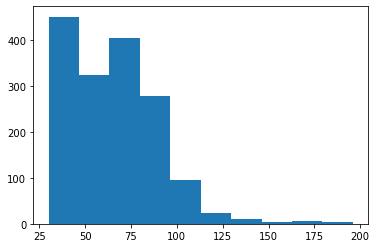

In [31]:
tmp = first_spike3[0,:]
plt.hist(tmp[np.isnan(tmp)!=1])

# plot example trial population synchrony

Text(0.5, 1.0, 'First spike on spike train for one trial')

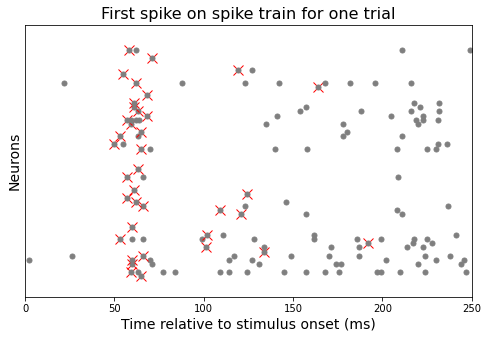

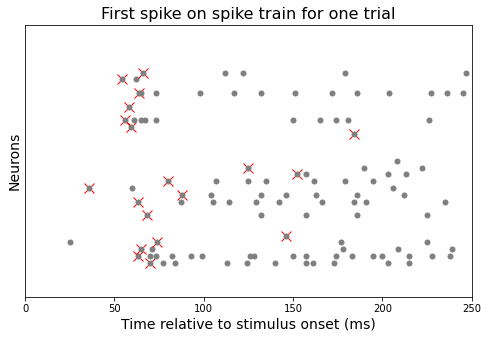

In [32]:
# plot example of first spike
spikes_select2 = spikes[np.where(df.cluster==2)[0],:,:]
spikes_select3 = spikes[np.where(df.cluster==3)[0],:,:]

spikes_trial_neuron = np.reshape(np.rollaxis(spikes_select2, 1,0), (spikes_select2.shape[0]*spikes_select2.shape[1], spikes_select2.shape[2]))
neuron=spikes_select2.shape[0]
cmap = plt.cm.get_cmap('tab10')

trial_idx=6

plt.figure(figsize=(8,5))
first_spike_tmp = first_spike2[:,trial_idx].astype(int)
for i in np.arange(neuron*trial_idx, neuron*(trial_idx+1)): #:
    if first_spike_tmp[i-neuron*trial_idx]>0:
        plt.plot(first_spike_tmp[i-neuron*trial_idx], i, 'x', color='red', markersize=10)
    tmp=np.where(spikes_trial_neuron[i,:250]==1)[0]
    c = cmap(0.1*i)
    plt.plot(tmp, i*np.ones(len(tmp)), '.', c=cmap(((i/neuron)+1)%10*0.1), markersize=10)
plt.ylim([neuron*trial_idx-5, neuron*(trial_idx+1)+5])
plt.xlim([0, 250])
plt.xlabel('Time relative to stimulus onset (ms)', fontsize=14)
plt.ylabel('Neurons', fontsize=14)
plt.yticks([])
plt.title('First spike on spike train for one trial', fontsize=16)
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/func_connect/cosyne/example_ttfs_cluster2.pdf')

spikes_trial_neuron = np.reshape(np.rollaxis(spikes_select3, 1,0), (spikes_select3.shape[0]*spikes_select3.shape[1], spikes_select2.shape[2]))
neuron=spikes_select3.shape[0]
cmap = plt.cm.get_cmap('tab10')
plt.figure(figsize=(8,5))
first_spike_tmp = first_spike3[:,trial_idx].astype(int)
for i in np.arange(neuron*trial_idx, neuron*(trial_idx+1)): #:
    if first_spike_tmp[i-neuron*trial_idx]>0:
        plt.plot(first_spike_tmp[i-neuron*trial_idx], i, 'x', color='red', markersize=10)
    tmp=np.where(spikes_trial_neuron[i,:250]==1)[0]
    c = cmap(0.1*i)
    plt.plot(tmp, i*np.ones(len(tmp)), '.', c=cmap(((i/neuron)+1)%10*0.1), markersize=10)
plt.ylim([neuron*trial_idx-5, neuron*(trial_idx+1)+5])
plt.xlim([0, 250])
plt.xlabel('Time relative to stimulus onset (ms)', fontsize=14)
plt.ylabel('Neurons', fontsize=14)
plt.yticks([])
plt.title('First spike on spike train for one trial', fontsize=16)
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/func_connect/cosyne/example_ttfs_cluster3.pdf')


In [33]:
spikes_select2.shape

(56, 1600, 2010)

Text(0, 0.5, 'Number of spike trains')

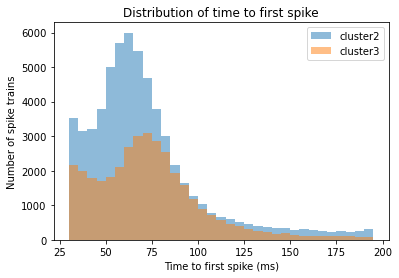

In [34]:
plt.hist(first_spike2.flatten()[first_spike2.flatten()!=0], bins=np.arange(start_time, end_time, 5), alpha=0.5, label='cluster2')
plt.hist(first_spike3.flatten()[first_spike3.flatten()!=0], bins=np.arange(start_time, end_time, 5), alpha=0.5, label='cluster3')
plt.legend()
plt.title('Distribution of time to first spike')
plt.xlabel('Time to first spike (ms)')
plt.ylabel('Number of spike trains')

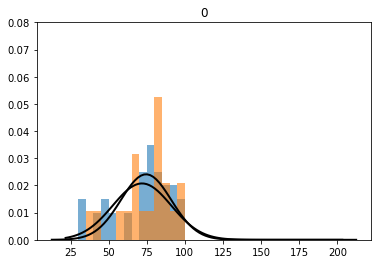

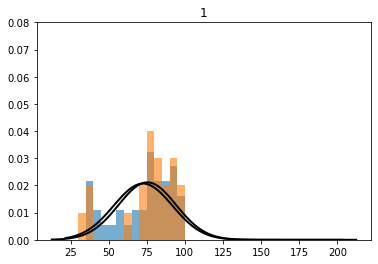

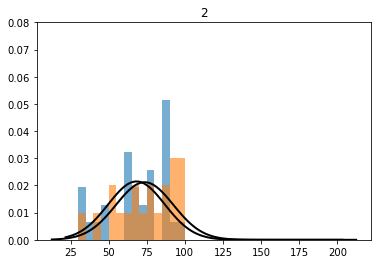

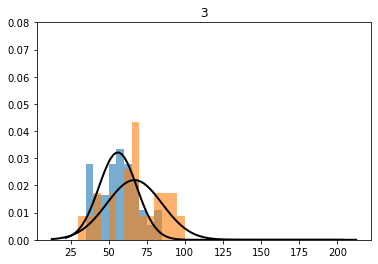

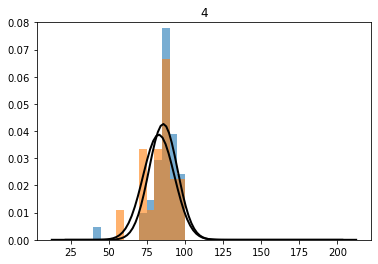

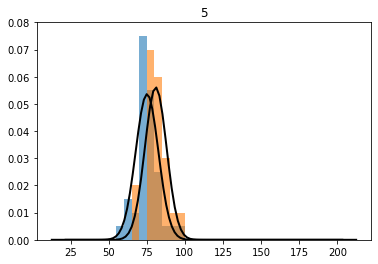

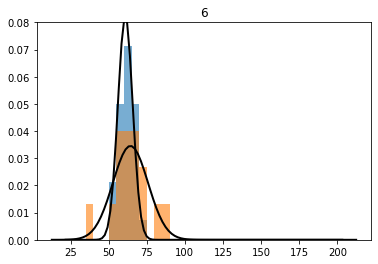

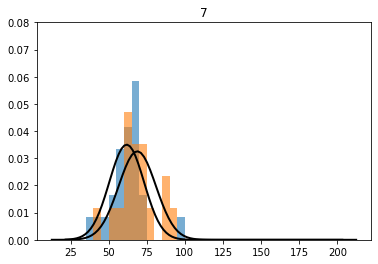

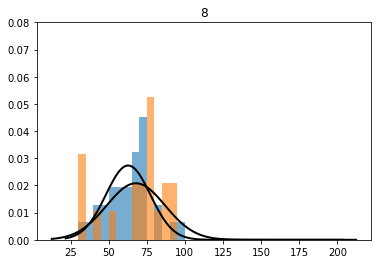

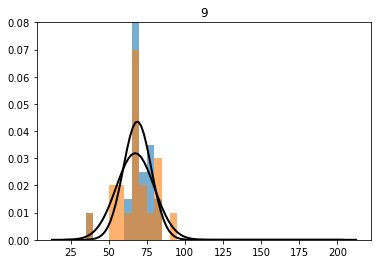

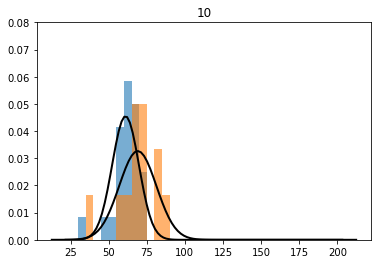

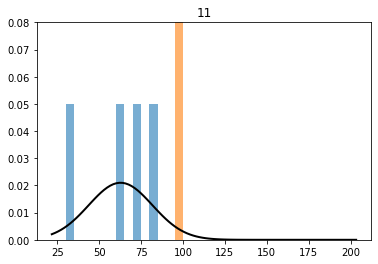

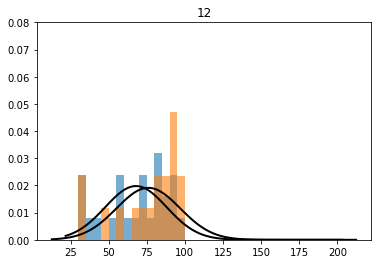

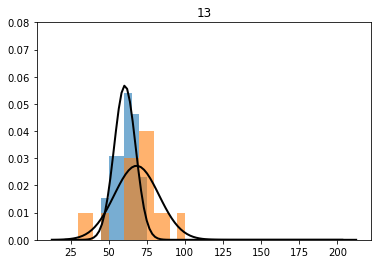

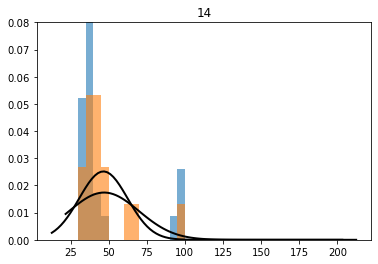

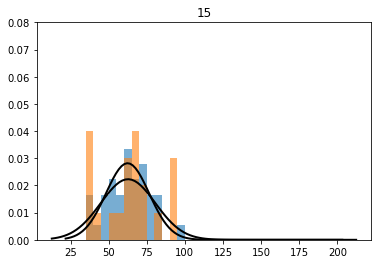

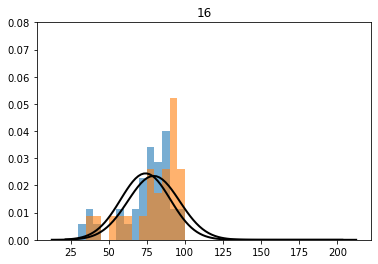

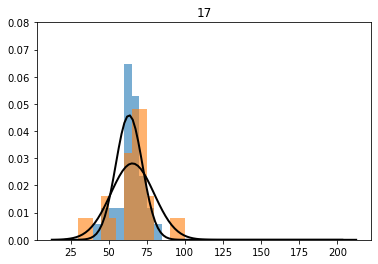

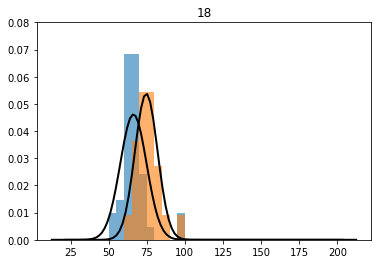

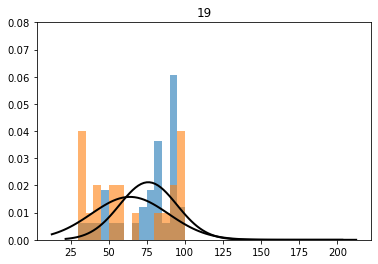

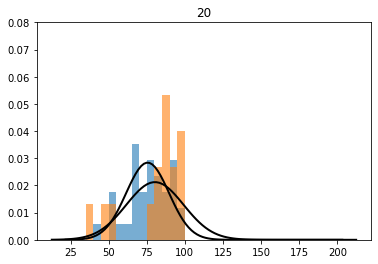

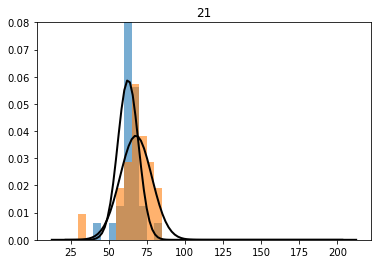

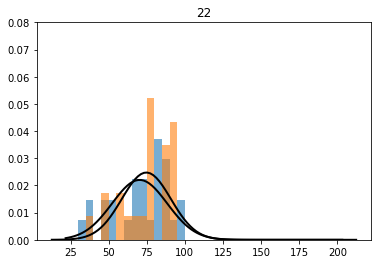

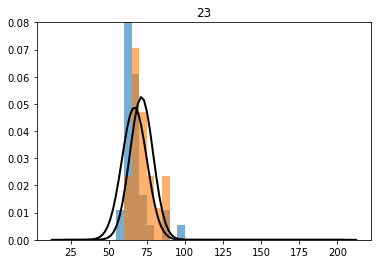

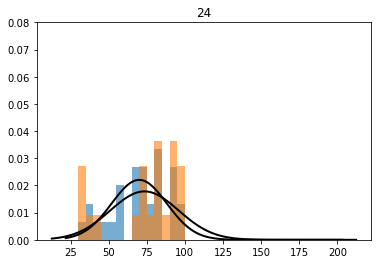

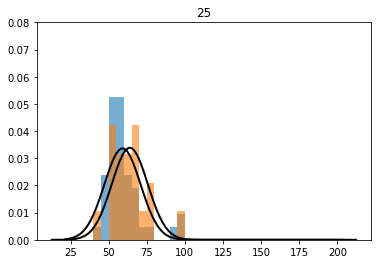

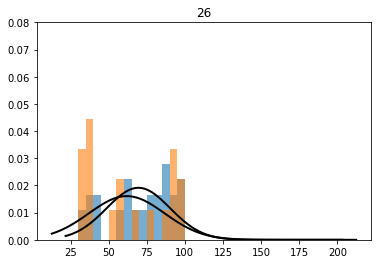

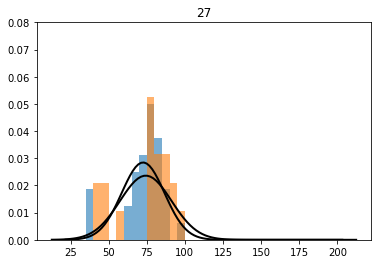

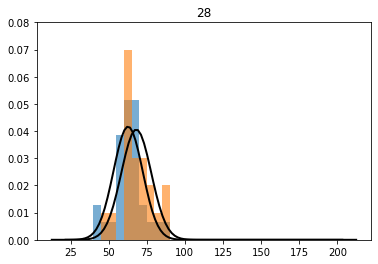

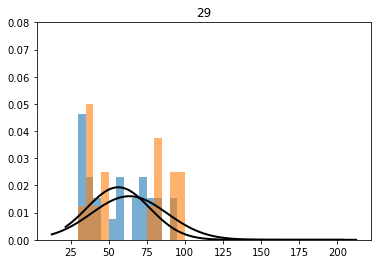

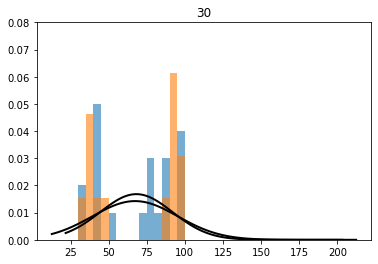

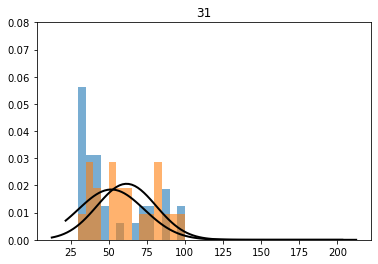

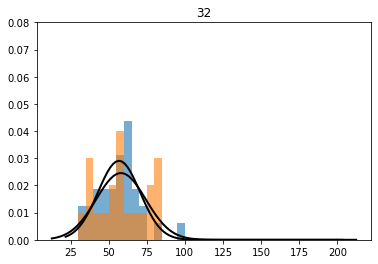

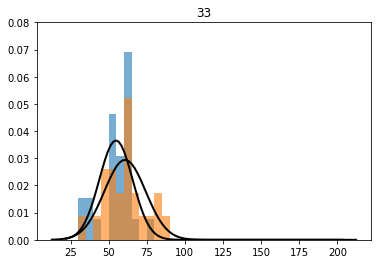

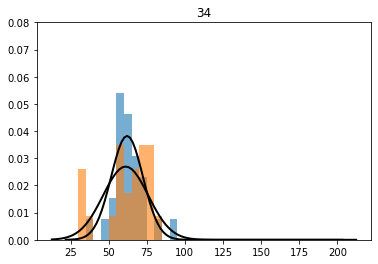

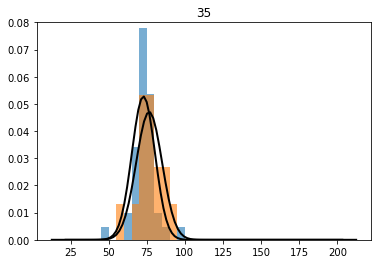

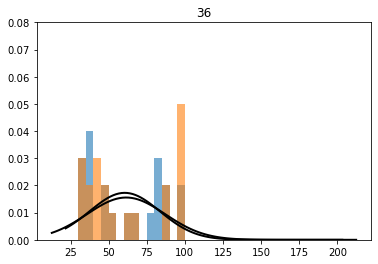

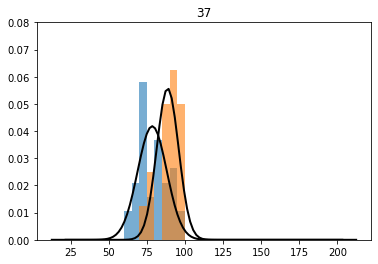

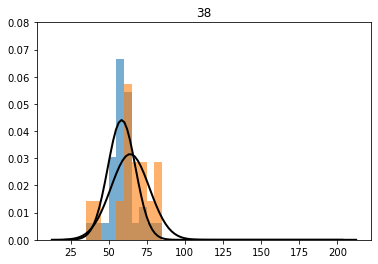

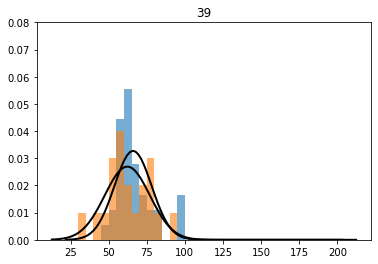

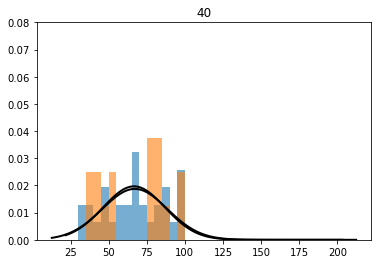

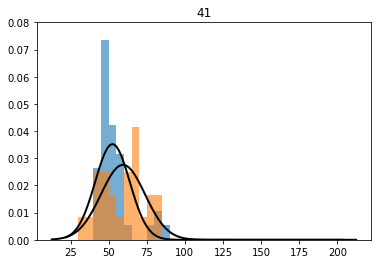

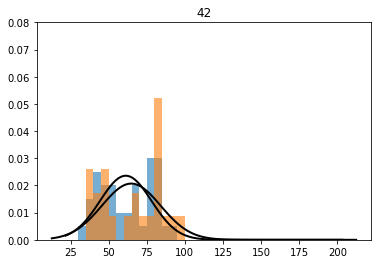

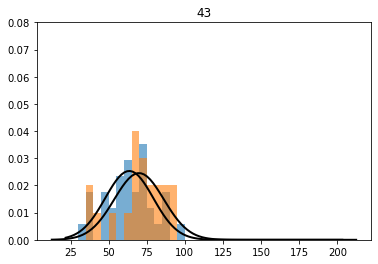

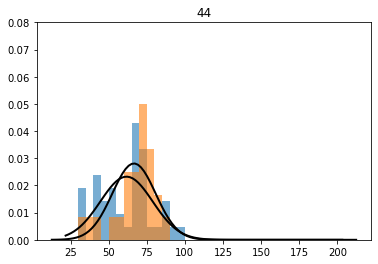

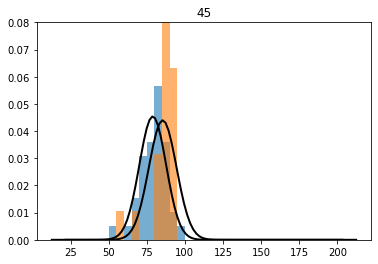

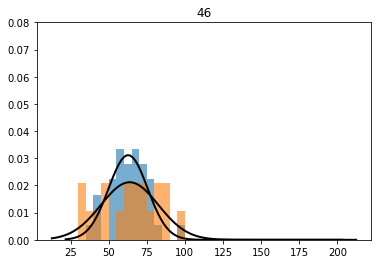

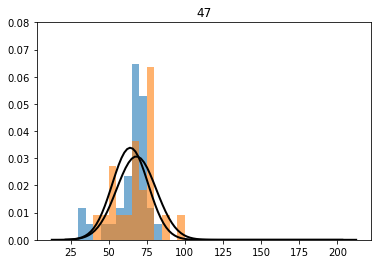

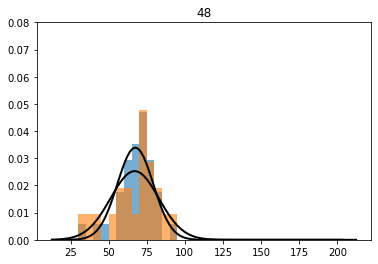

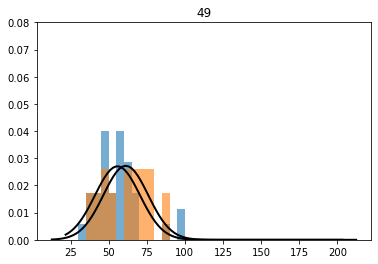

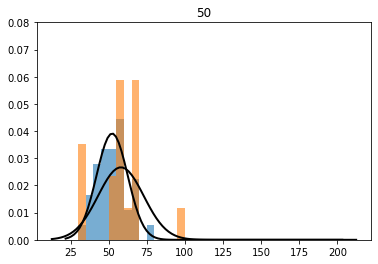

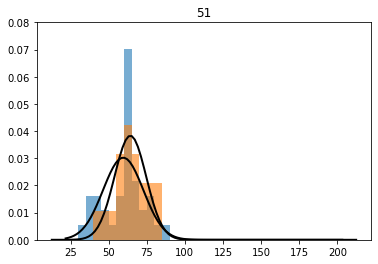

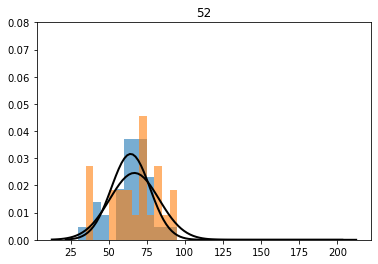

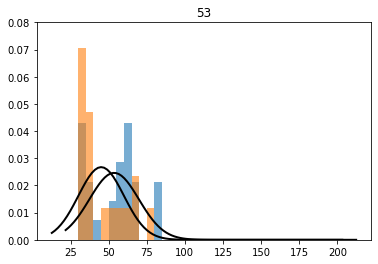

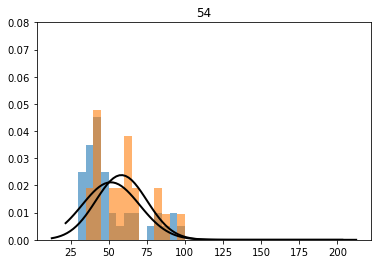

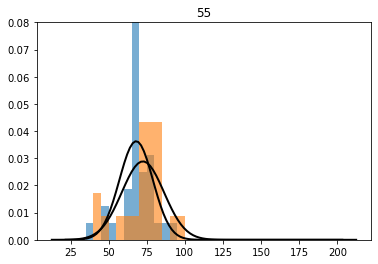

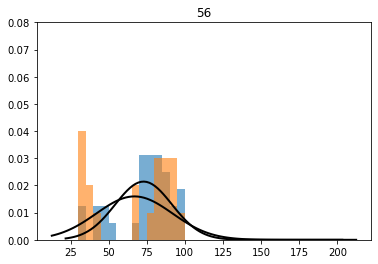

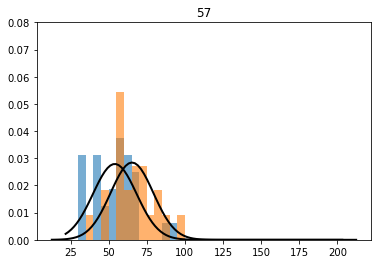

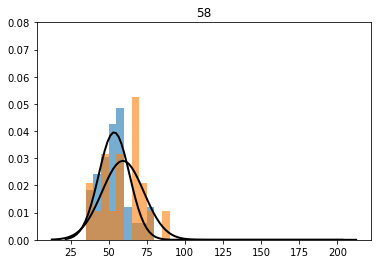

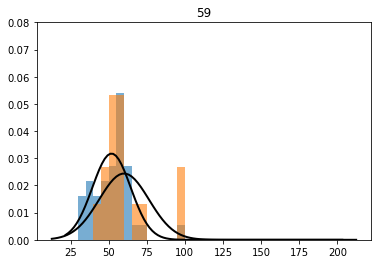

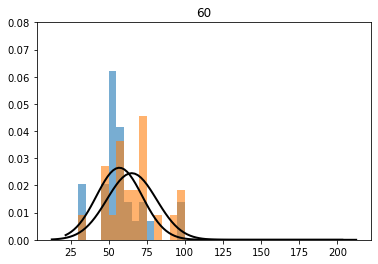

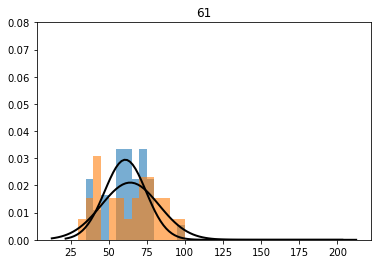

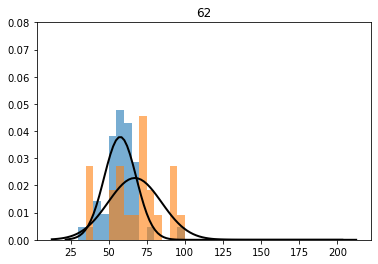

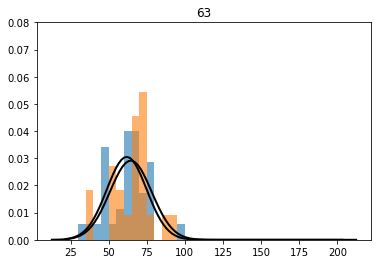

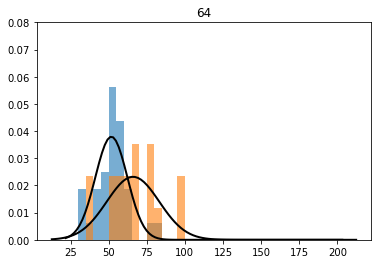

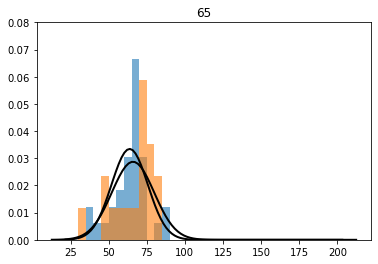

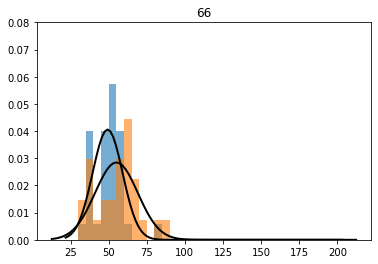

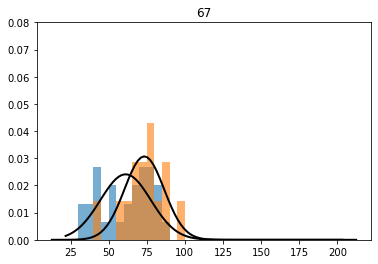

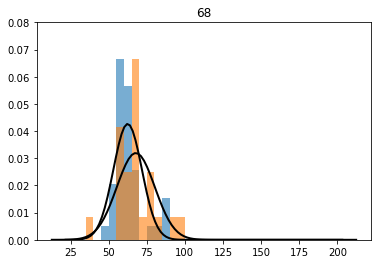

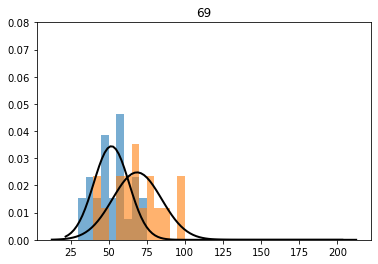

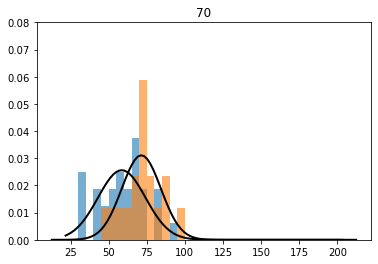

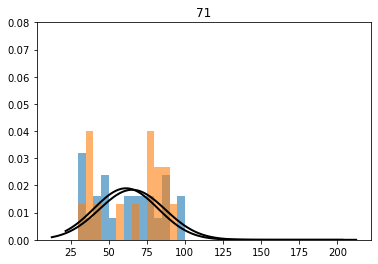

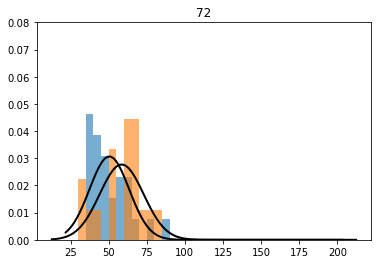

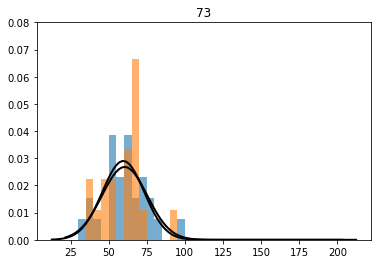

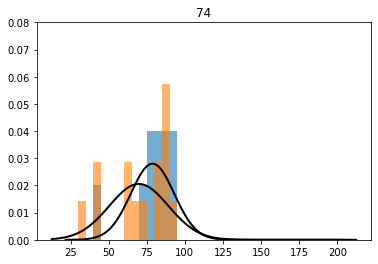

In [39]:
t=0
for t in range(75):
    plt.figure()
    dist_fit.fit_norm(first_spike2[:,t][np.where((first_spike2[:,t]>30) & (first_spike2[:,t]<100))[0]], bins=np.arange(start_time, end_time, 5), plot=True)
    plt.ylim([0,0.08])
    #plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/func_connect/cosyne/example_ttfs_std_cluster2.pdf')

    dist_fit.fit_norm(first_spike3[:,t][np.where((first_spike3[:,t]>30) & (first_spike3[:,t]<100))[0]], bins=np.arange(start_time, end_time, 5), plot=True)
    plt.ylim([0,0.08])
    #plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/func_connect/cosyne/example_ttfs_std_cluster3.pdf')
    plt.title(t)

In [46]:
# width of first peak distribution
n_trial=first_spike2.shape[1]
P2=np.nan*np.ones(n_trial)
P3=np.nan*np.ones(n_trial)
for t in range(first_spike3.shape[1]):
    mu, std = dist_fit.fit_norm(first_spike2[:,t][np.where((first_spike2[:,t]>30) & (first_spike2[:,t]<100))[0]])
    P2[t]=std
    mu, std = dist_fit.fit_norm(first_spike3[:,t][np.where((first_spike3[:,t]>30) & (first_spike3[:,t]<100))[0]])
    P3[t]=std

(array([  9.,  36.,  86., 192., 456., 495., 241.,  71.,   9.,   3.]),
 array([ 0.        ,  3.19517383,  6.39034766,  9.58552149, 12.78069532,
        15.97586915, 19.17104298, 22.36621681, 25.56139064, 28.75656447,
        31.9517383 ]),
 <a list of 10 Patch objects>)

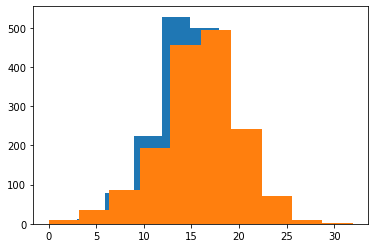

In [47]:
plt.hist(P2[np.isnan(P2)!=1])
plt.hist(P3[np.isnan(P3)!=1])

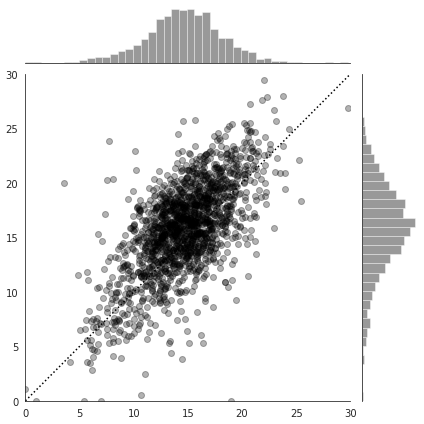

In [48]:
with sns.axes_style("white"):
    g=sns.jointplot(x=P2, y=P3, color="k", xlim=[0,30], ylim=[0,30]);
g.ax_joint.collections[0].set_alpha(0.3)

lims = [max(0, 0), min(30, 30)]
g.ax_joint.plot(lims, lims, ':k')  

#plt.xlabel('Peak width of cluster 2', fontsize=15)
#plt.ylabel('Peak width of cluster 3', fontsize=15)
#plt.title('Compactness of population response', fontsize=16)
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/func_connect/cosyne/example_mouse388523_std_ttfs.pdf')


# population summary: Gaussian fit mean and std; with RF constrain

(665, 480, 1510)
218 665
97 75 46
(559, 1600, 2010)
164 559
78 56 30
(560, 1600, 2010)
119 560
51 23 45
[0.8 0.1]
(633, 300, 2510)
174 633
79 43 52
[0.8 0.1]
(723, 300, 2510)
171 723
58 51 62
[0.8 0.1]
(536, 300, 2510)
200 536
57 97 46
[0.8 0.1]
(611, 300, 2510)
185 611
66 81 38
[0.8 0.1]
(616, 300, 2510)
131 616
55 48 28
[0.8 0.1]
(830, 300, 2510)
161 830
67 52 42
[0.8 0.1]
(578, 300, 2510)
240 578
58 110 72
[0.8 0.1]
(529, 300, 2510)
156 529
52 58 46
[0.8 0.1]
(767, 300, 2510)
171 767
63 48 60
[0.8 0.1]
(683, 300, 2510)
180 683
53 80 47
[0.8 0.1]
(599, 300, 2510)
180 599
97 42 41
[0.8 0.1]
(627, 300, 2510)
185 627
90 44 51
[0.8 0.1]
(546, 300, 2510)
165 546
89 37 39
[0.8 0.1]
(715, 300, 2510)
243 715
57 77 109
[0.8 0.1]
(655, 300, 2510)
204 655
119 16 69
[0.8 0.1]
(585, 300, 2510)
240 585
100 93 47


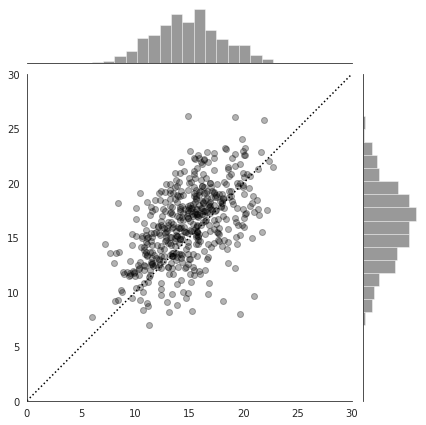

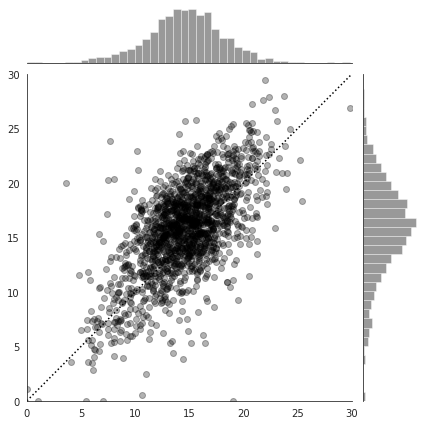

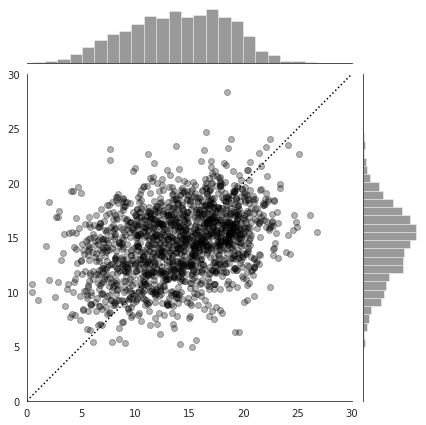

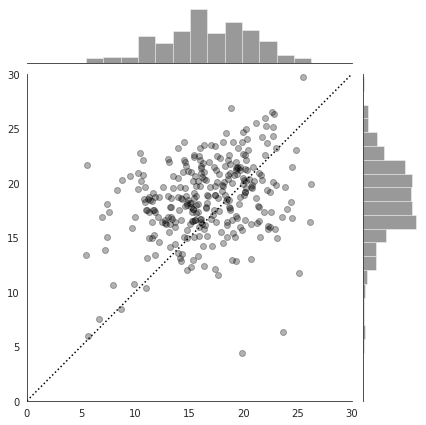

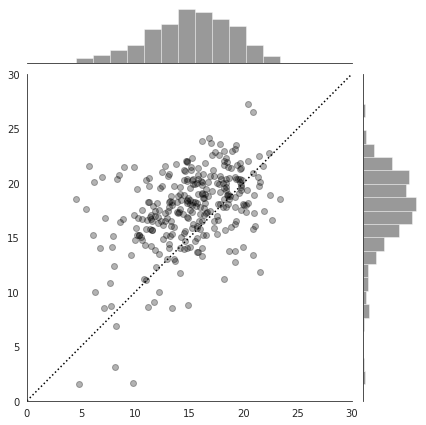

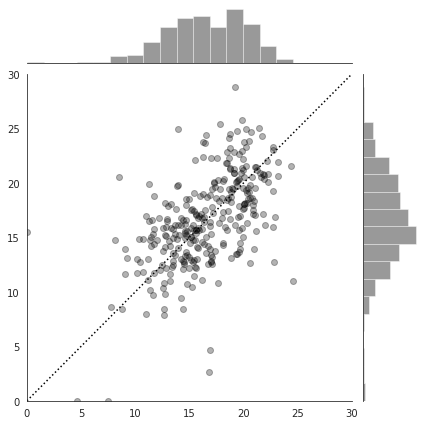

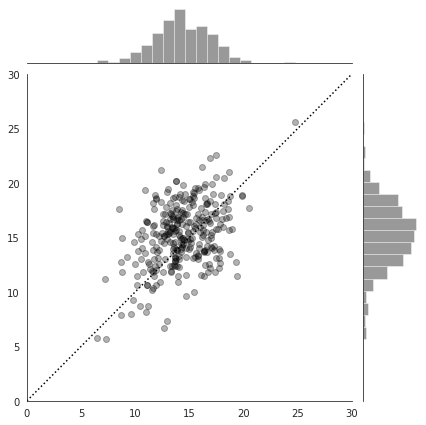

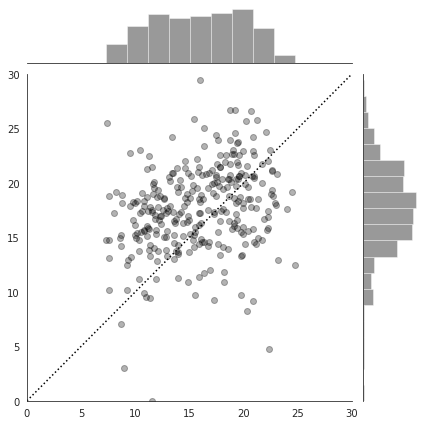

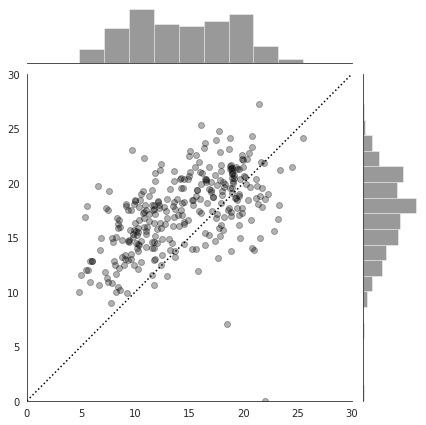

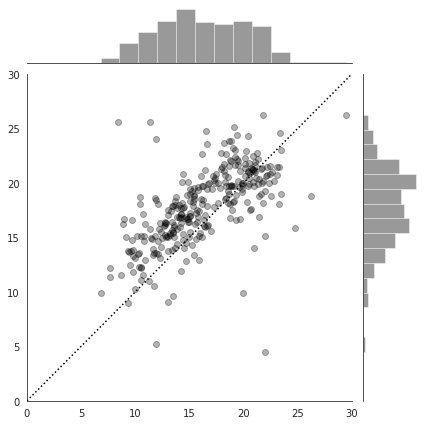

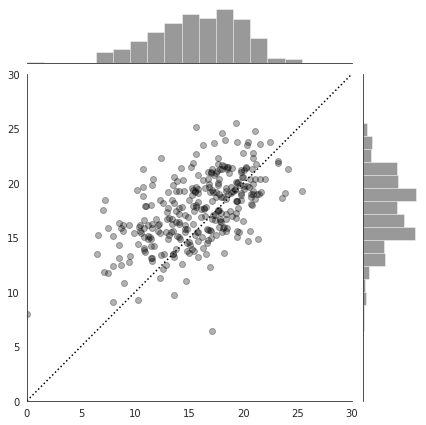

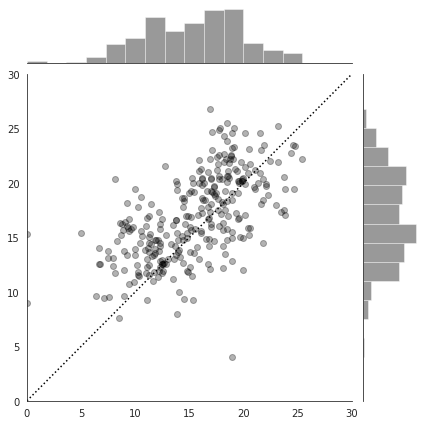

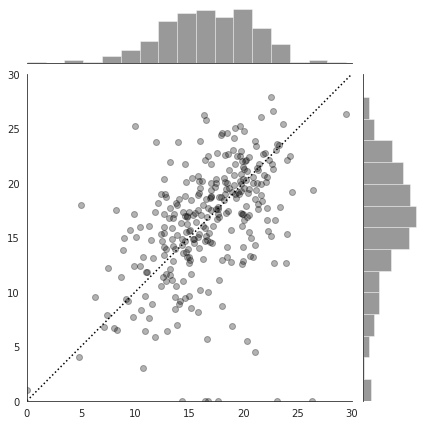

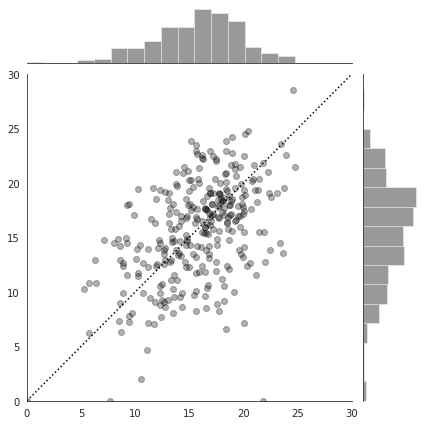

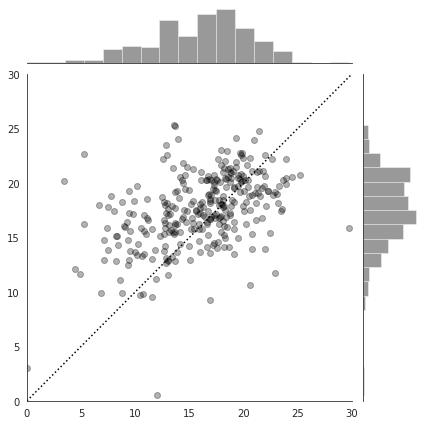

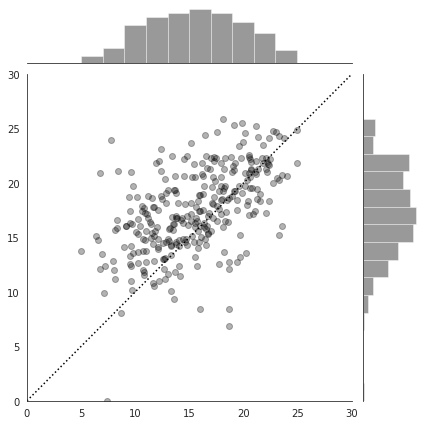

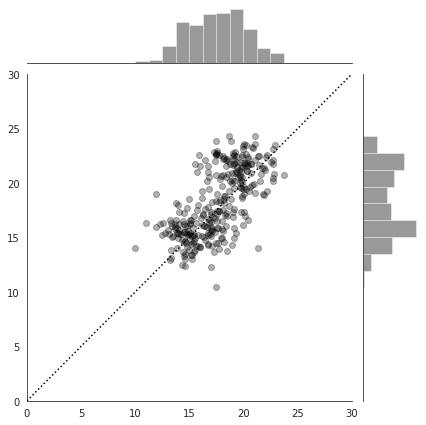

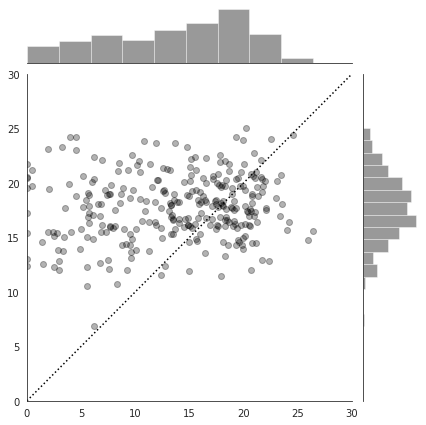

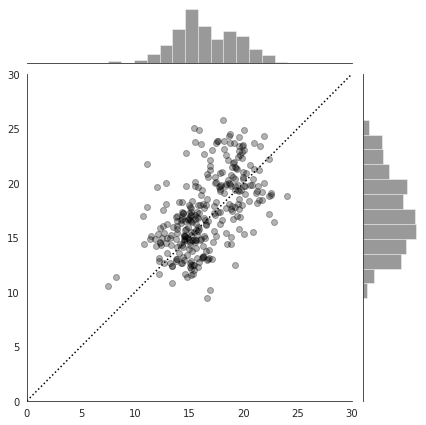

In [257]:
# all trials

mouse_IDs = ['306046','388523', '389262',  '408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356','416861','419112','419116'] #

#mouse_IDs = [ '306046',]

MP2=[]
MP3=[]
DF=[]
for mouse_ID in mouse_IDs:

    basepath = '/Users/xiaoxuanj/work/work_allen/Ephys/mouse'+mouse_ID
    spikes = dl.load_npz(basepath+'/matrix/drifting_grating_cortex.npz')
    #spikes_rep = dl.load_npz(basepath+'/matrix/drifting_grating_cortex_rep.npz')
    if int(mouse_ID)>389262:
        stim_table = pd.read_csv(glob.glob('/Users/xiaoxuanj/work/work_allen/Ephys/mouse'+'412809'+'/matrix/'+'stim_table_drifting*.csv')[0])
        print(stim_table["b'Contrast'"].unique())
        select_trials = np.where(stim_table["b'Contrast'"]>0.5)[0]
        spikes=spikes[:,select_trials,:]
    print(spikes.shape)

    df_tmp = pd.read_csv(basepath+'/matrix/mouse'+mouse_ID+'_cortex_meta.csv')
    df=pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/meta_cluster_RF/mouse'+mouse_ID+'_meta_cluster_RF.csv', index_col=0)
    df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0.1.1'])
    print(len(df),len(df_tmp))

    # 2. select units with RF on screen (already satisfy FR>2)
    select_idx = []
    for idx, row in df_tmp.iterrows():
        probe_id=row['probe_id']
        unit_id=row['unit_id']
        if unit_id in df[df.probe_id==probe_id].unit_id.values:
            select_idx.append(idx)      
    df_tmp=df_tmp.iloc[select_idx]

    spikes = spikes[select_idx]
    #spikes_rep = spikes_rep[select_idx]

    new_df = pd.merge(df_tmp, df,  how='left', left_on=['unit_id','probe_id'], right_on = ['unit_id','probe_id'])
    df = new_df
    DF.append(df)
    
    spikes_select1=spikes[df.cluster==1,:,:]
    spikes_select2=spikes[df.cluster==2,:,:]
    spikes_select3=spikes[df.cluster==3,:,:]
    print(len(spikes_select1), len(spikes_select2), len(spikes_select3))

    start_time=30
    end_time=200
    first_spike2 = tf.compute_first_spike(spikes_select2, start_time=start_time, end_time=end_time)
    first_spike3 = tf.compute_first_spike(spikes_select3, start_time=start_time, end_time=end_time)     
    
    # width of first peak distribution
    n_trial=first_spike2.shape[1]
    P2=np.nan*np.ones(n_trial)
    P3=np.nan*np.ones(n_trial)
    for t in range(first_spike3.shape[1]):
        mu, std = dist_fit.fit_norm(first_spike2[:,t][np.where((first_spike2[:,t]>30) & (first_spike2[:,t]<100))[0]])
        P2[t]=std
        mu, std = dist_fit.fit_norm(first_spike3[:,t][np.where((first_spike3[:,t]>30) & (first_spike3[:,t]<100))[0]])
        P3[t]=std
        
    MP2.append(P2)
    MP3.append(P3)
    
    with sns.axes_style("white"):
        g=sns.jointplot(x=P2, y=P3, color="k", xlim=[0,30], ylim=[0,30]);
    g.ax_joint.collections[0].set_alpha(0.3)

    lims = [max(0, 0), min(30, 30)]
    g.ax_joint.plot(lims, lims, ':k') 
    
    

DF=pd.concat(DF)
DF=DF.reset_index()

In [258]:
MP2_all =np.concatenate(MP2, axis=0)
MP3_all =np.concatenate(MP3, axis=0)


In [259]:
# shift 10 to accont for latency difference; final figure across all trials
np.save('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/data/TTF_population_trial_spread_RF_30100_removedlow.npy',[MP2_all, MP3_all])


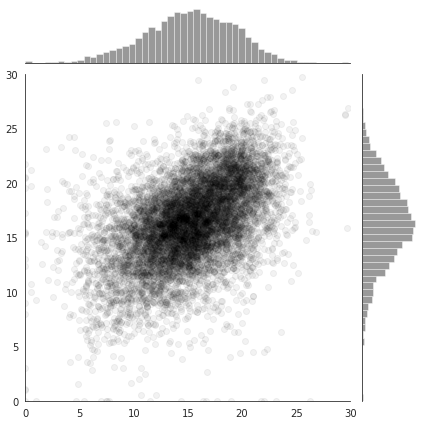

In [260]:
with sns.axes_style("white"):
    g=sns.jointplot(x=MP2_all, y=MP3_all, color="k", xlim=[0,30], ylim=[0,30]);
    #g=sns.jointplot(x=MP2_all, y=MP3_all, kind="hex", color="k", xlim=[0,30], ylim=[0,30]);
    #sns.jointplot(x=MP2_all, y=MP3_all, data=df, kind="kde", xlim=[0,30], ylim=[0,30]);
g.ax_joint.collections[0].set_alpha(0.05)

#lims = [max(0, 0), min(30, 30)]
#g.ax_joint.plot(lims, lims, ':k')  
#plt.savefig('/Users/xiaoxuanj/work/work_allen/Ephys/figures/func_connect/cosyne/summary_first_spike_synchrony_9mice_hex.pdf')


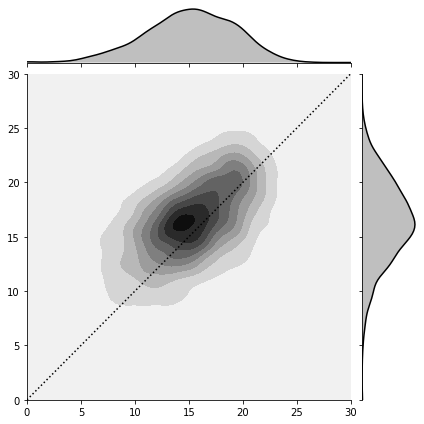

In [261]:
# hex hues
g = sns.jointplot(x=MP2_all, y=MP3_all, color="k", xlim=[0,30], ylim=[0,30], kind="kde")

lims = [max(0, 0), min(30, 30)]
g.ax_joint.plot(lims, lims, ':k') 

plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/summary_TTF_syn_19mice_samewindowwidth_RF_30100_kde.pdf')


In [262]:
MP2_all.shape

(8480,)

In [263]:
print(np.nanmean(MP3_all), np.nanstd(MP3_all))
print(np.nanmean(MP2_all), np.nanstd(MP2_all))

16.37554121658491 3.9712921948015496
15.108602979132462 4.2000046119891135


In [239]:
len(MP3_all[MP3_all!=np.NaN])

8480

In [240]:
from scipy.stats import pearsonr

In [264]:
from scipy.stats import ttest_ind
ttest_ind(MP3_all[np.isnan(MP3_all)!=1], MP2_all[np.isnan(MP2_all)!=1])

Ttest_indResult(statistic=20.156974391664097, pvalue=2.611266236229037e-89)

In [217]:
from scipy.stats import wilcoxon
w, p = wilcoxon(MP2_all, MP3_all)
print(w, p)

13367802.0 2.469847602728049e-92
